Simulating configurations:   0%|          | 0/3 [00:00<?, ?it/s]

Simulating configurations: 100%|██████████| 3/3 [00:49<00:00, 16.51s/it]


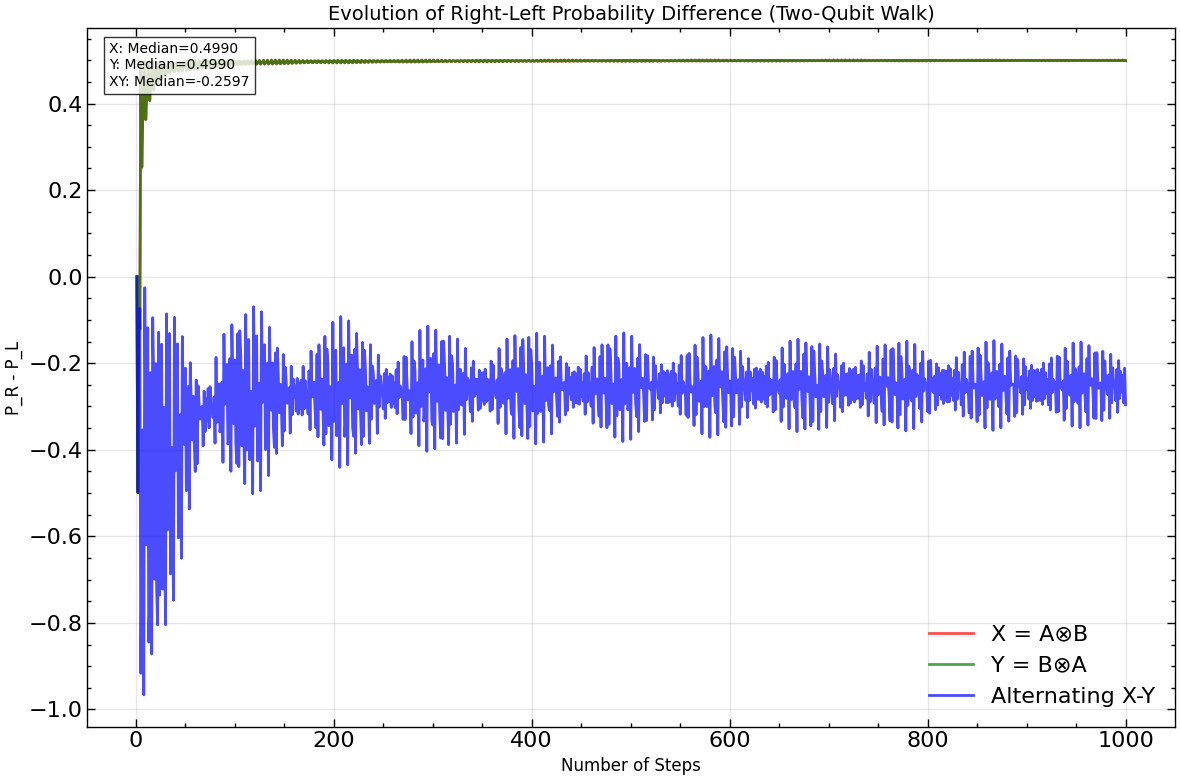

In [14]:
import matplotlib.pyplot as plt
from typing import Tuple, Optional, Dict
import numpy as np
from scipy.sparse import kron, csc_matrix
from tqdm import tqdm
import gc
from quantumwalks.discrete_walk import TwoQubitQuantumWalk
from quantumwalks.utils.operators import create_parametric_coin
import scienceplots
plt.style.use(['science','notebook'])

def calculate_lr_difference_two_qubit(prob: np.ndarray, max_steps: int) -> float:
    """Calculate P_R - P_L from probability distribution"""
    positions = np.arange(-max_steps, max_steps + 1)
    assert len(positions) == len(prob)

    # Check probability conservation
    if not np.allclose(np.sum(prob), 1.0, atol=1e-10):
        raise ValueError("Probability not conserved")

    P_L = np.sum(prob[positions < 0])
    P_R = np.sum(prob[positions > 0])
    return P_R - P_L

def compare_two_qubit_configurations(
    max_steps: int,
    coin_A_params: Tuple[float, float, float],
    coin_B_params: Tuple[float, float, float]
) -> Dict[str, np.ndarray]:
    """Compare P_R - P_L evolution for different two-qubit coin configurations"""

    # Create coin operators A and B
    coin_A = create_parametric_coin(*coin_A_params).toarray()
    coin_B = create_parametric_coin(*coin_B_params).toarray()

    # Create initial state (|10⟩ + i|01⟩)/√2
    initial_state = np.zeros(4, dtype=np.complex128)
    initial_state[0] = 1  # |00⟩ component
    initial_state[1] = 0  # |01⟩ component
    initial_state[2] = 0   # |10⟩ component
    initial_state[3] = 0  # |11⟩ component
    # initial_state /= np.sqrt(2)

    differences = {
        'X': np.zeros(max_steps),
        'Y': np.zeros(max_steps),
        'XY': np.zeros(max_steps)
    }

    try:
        # Simulate each configuration
        for config in tqdm(['X', 'Y', 'XY'], desc="Simulating configurations"):
            # Create quantum walk instance
            qw = TwoQubitQuantumWalk(
                num_steps=max_steps,
                initial_coin_state=initial_state
            )

            # Override shift operator
            def custom_shift():
                shift_right = np.roll(np.eye(qw.P), 1, axis=0)
                shift_left = np.roll(np.eye(qw.P), -1, axis=0)
                stay = np.eye(qw.P)

                P00 = qw.basis_states[0].dot(qw.basis_states[0].T.conjugate())
                P01 = qw.basis_states[1].dot(qw.basis_states[1].T.conjugate())
                P10 = qw.basis_states[2].dot(qw.basis_states[2].T.conjugate())
                P11 = qw.basis_states[3].dot(qw.basis_states[3].T.conjugate())

                return (kron(csc_matrix(shift_right), P00) +  # |00⟩ → right
                       kron(csc_matrix(stay), P01) +          # |01⟩ → stay
                       kron(csc_matrix(stay), P10) +          # |10⟩ → stay
                       kron(csc_matrix(shift_left), P11))     # |11⟩ → left

            qw.create_four_way_shift = custom_shift

            if config == 'X':
                qw.coin1, qw.coin2 = coin_A, coin_B
                final_prob, _, prob_history = qw.simulate()
            elif config == 'Y':
                qw.coin1, qw.coin2 = coin_B, coin_A
                final_prob, _, prob_history = qw.simulate()
            else:  # XY alternating
                # Initialize with X configuration
                psi = kron(qw.posn0, qw.initial_coin_state)
                qw._validate_quantum_state(psi)

                shift_op = custom_shift()
                prob_history = [qw.calculate_probabilities(psi)]

                # Create X and Y operators
                X = kron(coin_A, coin_B)
                Y = kron(coin_B, coin_A)

                for step in range(max_steps):
                    # Choose coin operator based on step
                    current_coin = X if step % 2 == 0 else Y
                    coin_op = kron(csc_matrix(np.eye(qw.P)), csc_matrix(current_coin))

                    # Evolution
                    psi = coin_op.dot(psi)
                    psi = shift_op.dot(psi)

                    qw._validate_quantum_state(psi)
                    prob_history.append(qw.calculate_probabilities(psi))

                final_prob = prob_history[-1]

            # Calculate P_R - P_L for each step
            for step in range(max_steps):
                differences[config][step] = calculate_lr_difference_two_qubit(
                    prob_history[step], max_steps
                )

        return differences

    finally:
        gc.collect()

def plot_two_qubit_differences(
    differences: Dict[str, np.ndarray],
    coin_params: Dict[str, Tuple[float, float, float]],
    max_steps: int
):
    """Plot P_R - P_L evolution for different configurations"""
    plt.figure(figsize=(12, 8))
    steps = np.arange(1, max_steps + 1)

    # Plot configurations
    plt.plot(steps, differences['X'], 'r-',
             label='X = A⊗B', alpha=0.7)
    plt.plot(steps, differences['Y'], 'g-',
             label='Y = B⊗A', alpha=0.7)
    plt.plot(steps, differences['XY'], 'b-',
             label='Alternating X-Y', alpha=0.7)

    plt.grid(True, alpha=0.3)
    plt.xlabel('Number of Steps', fontsize=12)
    plt.ylabel('P_R - P_L', fontsize=12)
    plt.title('Evolution of Right-Left Probability Difference (Two-Qubit Walk)',
             fontsize=14)
    plt.legend()

    # Add median values
    median_text = []
    for config in ['X', 'Y', 'XY']:
        median_diff = np.median(differences[config])
        median_text.append(f"{config}: Median={median_diff:.4f}")

    plt.text(0.02, 0.98, '\n'.join(median_text),
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Set parameters
    max_steps = 1000

    # Parameters for coins A and B (in radians)
    coin_A_params = (-51.0/180 * np.pi,  # alpha
                     45.0/180 * np.pi,   # beta
                      0.0/180 * np.pi)   # gamma

    coin_B_params = (0.0/180 * np.pi,    # alpha
                    88.0/180 * np.pi,    # beta
                   -16.0/180 * np.pi)    # gamma

    try:
        # Calculate P_R - P_L evolution
        differences = compare_two_qubit_configurations(
            max_steps=max_steps,
            coin_A_params=coin_A_params,
            coin_B_params=coin_B_params
        )

        # Plot results
        coin_params = {
            "A": coin_A_params,
            "B": coin_B_params
        }

        plot_two_qubit_differences(differences, coin_params, max_steps)

    except Exception as e:
        print(f"Error during simulation: {str(e)}")


## class implementation

Simulating configurations: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


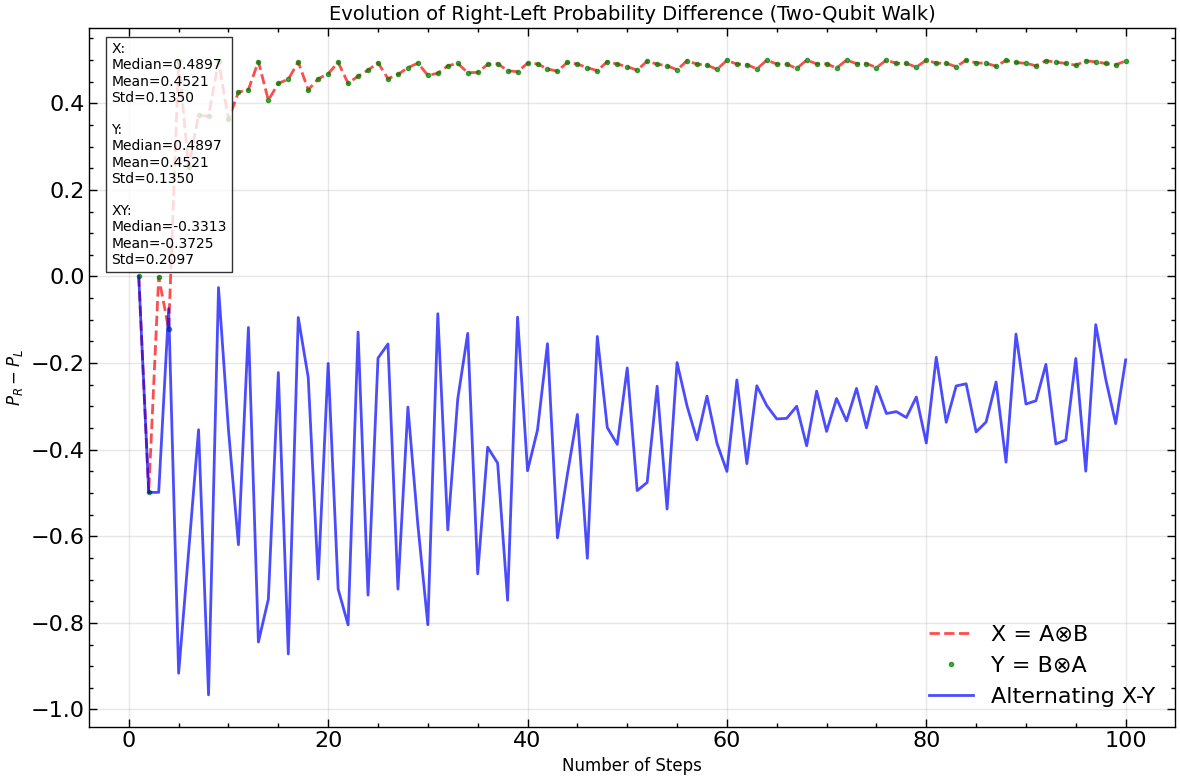

In [13]:
import matplotlib.pyplot as plt
from typing import Tuple, Optional, Dict, Union, Callable
import numpy as np
from scipy.sparse import kron, csc_matrix
from tqdm import tqdm
import gc
from dataclasses import dataclass
from quantumwalks.discrete_walk import TwoQubitQuantumWalk
from quantumwalks.utils.operators import create_parametric_coin
import scienceplots
plt.style.use(['science','notebook'])

@dataclass
class WalkParameters:
    """Parameters for two-qubit quantum walk configuration"""
    max_steps: int
    coin_A_params: Tuple[float, float, float]
    coin_B_params: Tuple[float, float, float]
    initial_state: Optional[np.ndarray] = None
    alternating_pattern: Optional[str] = "simple"
    memory_efficient: bool = True

class TwoQubitParrondoWalk:
    """Implementation of Parrondo's paradox using two-qubit quantum walk"""
    
    def __init__(self, params: WalkParameters):
        """
        Initialize the walk configuration
        
        Args:
            params: WalkParameters object containing configuration
        """
        self.validate_parameters(params)
        self.params = params
        self.setup_initial_state()
        self.setup_coin_operators()
        
    @staticmethod
    def validate_parameters(params: WalkParameters) -> None:
        """Validate input parameters"""
        if params.max_steps < 1:
            raise ValueError("Number of steps must be positive")
        
        if not all(isinstance(p, tuple) and len(p) == 3 
                  for p in [params.coin_A_params, params.coin_B_params]):
            raise ValueError("Coin parameters must be tuples of length 3")
            
        if params.alternating_pattern not in ["simple", "random", "periodic"]:
            raise ValueError("Invalid alternating pattern")
            
    def setup_initial_state(self) -> None:
        """Setup initial quantum state"""
        if self.params.initial_state is None:
            # Default state (|10⟩ + i|01⟩)/√2
            self.initial_state = np.zeros(4, dtype=np.complex128)
            self.initial_state[0] = 1  # |00⟩ component
            self.initial_state[1] = 0  # |01⟩ component
            self.initial_state[2] = 0   # |10⟩ component
            self.initial_state[3] = 0  # |11⟩ component
            # self.initial_state /= np.sqrt(2)
        else:
            # Validate and normalize custom initial state
            if len(self.params.initial_state) != 4:
                raise ValueError("Initial state must be 4-dimensional")
            norm = np.linalg.norm(self.params.initial_state)
            if not np.isclose(norm, 1.0):
                self.initial_state = self.params.initial_state / norm
            else:
                self.initial_state = self.params.initial_state

    def setup_coin_operators(self) -> None:
        """Setup coin operators A and B"""
        self.coin_A = create_parametric_coin(*self.params.coin_A_params).toarray()
        self.coin_B = create_parametric_coin(*self.params.coin_B_params).toarray()
        
        # Precompute tensor products
        self.X_operator = kron(self.coin_A, self.coin_B)
        self.Y_operator = kron(self.coin_B, self.coin_A)

    def create_custom_shift(self, qw: TwoQubitQuantumWalk) -> csc_matrix:
        """Create custom shift operator for the walk"""
        shift_right = np.roll(np.eye(qw.P), 1, axis=0)
        shift_left = np.roll(np.eye(qw.P), -1, axis=0)
        stay = np.eye(qw.P)

        # Create projectors
        projectors = [state.dot(state.T.conjugate()) 
                     for state in qw.basis_states]

        return (kron(csc_matrix(shift_right), projectors[0]) +
               kron(csc_matrix(stay), projectors[1]) +
               kron(csc_matrix(stay), projectors[2]) +
               kron(csc_matrix(shift_left), projectors[3]))

    def get_coin_sequence(self) -> np.ndarray:
        """Generate coin sequence based on alternating pattern"""
        if self.params.alternating_pattern == "simple":
            return np.array([0 if i % 2 == 0 else 1 
                           for i in range(self.params.max_steps)])
        elif self.params.alternating_pattern == "random":
            return np.random.randint(0, 2, self.params.max_steps)
        else:  # periodic
            period = 4
            return np.tile([0, 0, 1, 1], self.params.max_steps // period + 1
                         )[:self.params.max_steps]

    def calculate_lr_difference(self, prob: np.ndarray) -> float:
        """Calculate P_R - P_L from probability distribution"""
        positions = np.arange(-self.params.max_steps, self.params.max_steps + 1)
        
        if not np.allclose(np.sum(prob), 1.0, atol=1e-10):
            raise ValueError("Probability not conserved")

        P_L = np.sum(prob[positions < 0])
        P_R = np.sum(prob[positions > 0])
        return P_R - P_L

    def simulate_configuration(self, config_type: str) -> np.ndarray:
        """
        Simulate a specific walk configuration
        
        Args:
            config_type: One of 'X', 'Y', or 'XY'
            
        Returns:
            np.ndarray: Array of P_R - P_L differences
        """
        qw = TwoQubitQuantumWalk(
            num_steps=self.params.max_steps,
            initial_coin_state=self.initial_state
        )
        
        # Override the shift operator
        qw.create_four_way_shift = lambda: self.create_custom_shift(qw)

        if config_type in ['X', 'Y']:
            qw.coin1 = self.coin_A if config_type == 'X' else self.coin_B
            qw.coin2 = self.coin_B if config_type == 'X' else self.coin_A
            _, _, prob_history = qw.simulate()
        else:  # XY alternating
            prob_history = self.simulate_alternating(qw)

        differences = np.zeros(self.params.max_steps)
        for step in range(self.params.max_steps):
            differences[step] = self.calculate_lr_difference(prob_history[step])

        return differences

    def simulate_alternating(self, qw: TwoQubitQuantumWalk) -> list:
        """Simulate alternating coin configuration"""
        psi = kron(qw.posn0, csc_matrix(self.initial_state).T)
        shift_op = qw.create_four_way_shift()
        prob_history = [qw.calculate_probabilities(psi)]
        
        coin_sequence = self.get_coin_sequence()
        eye_P = csc_matrix(np.eye(qw.P))

        for step in range(self.params.max_steps):
            current_coin = self.X_operator if coin_sequence[step] == 0 else self.Y_operator
            coin_op = kron(eye_P, csc_matrix(current_coin))
            
            psi = coin_op.dot(psi)
            psi = shift_op.dot(psi)
            
            prob_history.append(qw.calculate_probabilities(psi))
            
            if self.params.memory_efficient:
                gc.collect()

        return prob_history

    def run_comparison(self) -> Dict[str, np.ndarray]:
        """Run comparison of all configurations"""
        differences = {}
        
        try:
            for config in tqdm(['X', 'Y', 'XY'], desc="Simulating configurations"):
                differences[config] = self.simulate_configuration(config)
                if self.params.memory_efficient:
                    gc.collect()
                    
            return differences
            
        except Exception as e:
            raise RuntimeError(f"Simulation failed: {str(e)}")

    def plot_results(self, differences: Dict[str, np.ndarray]):
        """Plot comparison results"""
        plt.figure(figsize=(12, 8))
        steps = np.arange(1, self.params.max_steps + 1)

        colors = {'X': 'r--', 'Y': 'g.', 'XY': 'b-'}
        labels = {'X': 'X = A⊗B', 'Y': 'Y = B⊗A', 'XY': 'Alternating X-Y'}

        for config in differences:
            plt.plot(steps, differences[config], colors[config],
                    label=labels[config], alpha=0.7)

        plt.grid(True, alpha=0.3)
        plt.xlabel('Number of Steps', fontsize=12)
        plt.ylabel(r'$P_R - P_L$', fontsize=12)
        plt.title('Evolution of Right-Left Probability Difference (Two-Qubit Walk)',
                 fontsize=14)
        plt.legend()

        # Add statistics
        stats_text = []
        for config in differences:
            median = np.median(differences[config])
            mean = np.mean(differences[config])
            std = np.std(differences[config])
            stats_text.append(f"{config}:\nMedian={median:.4f}\n"
                            f"Mean={mean:.4f}\nStd={std:.4f}")

        plt.text(0.02, 0.98, '\n\n'.join(stats_text),
                transform=plt.gca().transAxes,
                bbox=dict(facecolor='white', alpha=0.8),
                verticalalignment='top')

        plt.tight_layout()
        plt.show()

def main():
    # Example parameters
    params = WalkParameters(
        max_steps=100,
        coin_A_params=(-51.0/180 * np.pi, 45.0/180 * np.pi, 0.0/180 * np.pi),
        coin_B_params=(0.0/180 * np.pi, 88.0/180 * np.pi, -16.0/180 * np.pi),
        alternating_pattern="simple",
        memory_efficient=True
    )

    try:
        walk = TwoQubitParrondoWalk(params)
        differences = walk.run_comparison()
        walk.plot_results(differences)
        
    except Exception as e:
        print(f"Error during simulation: {str(e)}")

if __name__ == "__main__":
    main()